In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.stats import spearmanr, pearsonr

import ast

# logging config
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# read processed data
df = pd.read_csv('../data/twitter/train_processed.csv', encoding='latin-1')
df['processed_text'] = df['processed_text'].apply(lambda x: ast.literal_eval(x))

In [3]:
tokenized_sentences = list(df['processed_text'])

In [4]:
# train the model
# change vector size, epochs, negative samples

models = {}
vector_sizes = [128, 256, 300]
windows = [5, 10, 15]
negative_samples = [10, 15, 20]

# train the model using different parameters
for v in vector_sizes:
    for w in windows:
        for ns in negative_samples:
            model = Word2Vec(
                tokenized_sentences,
                vector_size=v,
                window=w,
                min_count=1,
                sg=1,
                epochs=10, # fix number of epochs at 10
                negative=ns,
                workers=12
            )

            # save each model in a dictionary, then pick best one later
            models[(v, w, ns)] = model

2025-08-20 14:09:23,820 : INFO : collecting all words and their counts
2025-08-20 14:09:23,820 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-08-20 14:09:23,838 : INFO : collected 11926 word types from a corpus of 58038 raw words and 8000 sentences
2025-08-20 14:09:23,838 : INFO : Creating a fresh vocabulary
2025-08-20 14:09:23,867 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 11926 unique words (100.00% of original 11926, drops 0)', 'datetime': '2025-08-20T14:09:23.867501', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-08-20 14:09:23,867 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 58038 word corpus (100.00% of original 58038, drops 0)', 'datetime': '2025-08-20T14:09:23.867501', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [M

In [5]:
# save the trained models in case we need to use it again
for k in models.keys():
    vector_size, window, negative_samples = k
    models[k].save(f'./models/word2vec/skipgram_{vector_size}_{window}_{negative_samples}.model')

2025-08-20 14:11:40,333 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec/skipgram_128_5_10.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-20T14:11:40.333445', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-20 14:11:40,335 : INFO : not storing attribute cum_table
2025-08-20 14:11:40,363 : INFO : saved ./models/word2vec/skipgram_128_5_10.model
2025-08-20 14:11:40,365 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec/skipgram_128_5_15.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-20T14:11:40.365683', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-20 14:11:40,365 : INFO : not stori

## Analysis

### Evaluation of quality of embeddings of each model with Wordsim353

In [6]:
def evaluate_correlation_wordsim(df, model):
    # make a copy of df to not change it
    df1 = df.copy()

    # compute similarity scores
    preds = []
    for _, row in df1.iterrows():
        w1, w2 = row['Word 1'], row['Word 2']
        if w1 in model.wv and w2 in model.wv:
            sim = model.wv.similarity(w1, w2)
            preds.append(sim)
        else:
            preds.append(np.nan) # result not available

    df1['preds'] = preds
    df1 = df1.dropna()

    # compute correlations
    print("Spearman correlation:", spearmanr(df1['preds'], df1['Human (Mean)'])[0])
    print("Pearson correlation:", pearsonr(df1['preds'], df1['Human (Mean)'])[0])

In [7]:
wordsim = pd.read_csv('../data/evaluation/wordsim353crowd.csv')

In [8]:
for k, model in models.items():
    vector_size, window, negative_samples = k
    print(f'Model parameters are: vector size = {vector_size}, window = {window}, negative samples = {negative_samples}')
    evaluate_correlation_wordsim(wordsim, model)
    print("*" * 50)

Model parameters are: vector size = 128, window = 5, negative samples = 10
Spearman correlation: 0.09392324476735468
Pearson correlation: 0.0618920699726335
**************************************************
Model parameters are: vector size = 128, window = 5, negative samples = 15
Spearman correlation: 0.11309538330060814
Pearson correlation: 0.07992704521918224
**************************************************
Model parameters are: vector size = 128, window = 5, negative samples = 20
Spearman correlation: 0.1531102266046884
Pearson correlation: 0.08858370862876346
**************************************************
Model parameters are: vector size = 128, window = 10, negative samples = 10
Spearman correlation: 0.12752849536734168
Pearson correlation: 0.0956108924286382
**************************************************
Model parameters are: vector size = 128, window = 10, negative samples = 15
Spearman correlation: 0.14647254178916924
Pearson correlation: 0.1121407667506433
********

Best model parameters based on Spearman correlation for word2vec are: vector size = 128, window = 15, negative samples = 15.

Use these parameters for subsequent analysis on the word2vec embeddings.

### Nearest Neighbours for selected words

In [13]:
best_model = models[(128, 15, 15)] # pick the best model

selected_words = [
    'sad',
    'chocolate',
    'chemistry',
    'month',
    'news'
]

for word in selected_words:
    print(f'Word is: {word}')
    print(best_model.wv.most_similar(word))
    print("*" * 30)

Word is: sad
[('cry', 0.8886730074882507), ('soo', 0.8764680027961731), ('funny', 0.8651209473609924), ('worried', 0.8591858744621277), ('died', 0.8527159690856934), ('although', 0.8497557044029236), ('hahaha', 0.8494905233383179), ('classmate', 0.8480225801467896), ('care', 0.8476229310035706), ('darn', 0.8465439081192017)]
******************************
Word is: chocolate
[('amberoshia', 0.9905381202697754), ('workim', 0.9901556968688965), ('weight', 0.9900749921798706), ('itch', 0.9897929430007935), ('exercise', 0.9896405339241028), ('fourth', 0.98914635181427), ('pattern', 0.9891120195388794), ('ppr', 0.9890832901000977), ('heel', 0.9889056086540222), ('4pm', 0.9887327551841736)]
******************************
Word is: chemistry
[('cozy', 0.9958847165107727), ('palace', 0.9957905411720276), ('relaxing', 0.9955322742462158), ('aaaah', 0.9951947927474976), ('teacher', 0.9950580596923828), ('crabby', 0.9948287606239319), ('127', 0.9947288036346436), ('ohhh', 0.994665265083313), ('rugb

Similar words are sometimes unreasonable, like for chemistry or chocolate. Even though there is a high similarity score between chemistry and cozy, they are not similar in meaning.

Other similar words seem to be more reasonable, like for sad, month and news.

### Visualization of PCA embedding space

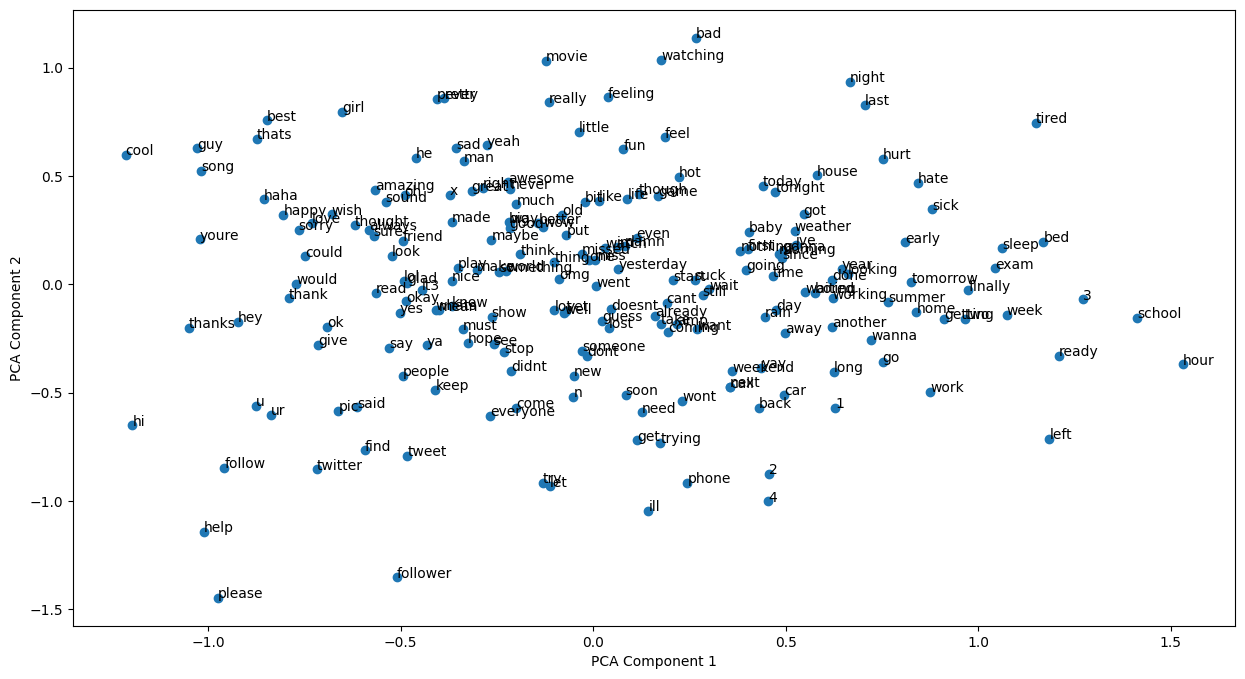

In [14]:
words = list(best_model.wv.index_to_key[0:200])
embeddings = best_model.wv[words]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

The words seem to take up most of the 2 dimensional space. There aren't really obvious clusters.

There some words that are semantically similar and close to each other, like 'u' and 'ur'.

However, there are also other words that are not semantically similar, but are close to each other. One example is 'sorry', 'happy' and 'love'.